In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
import time 
from natsort import natsorted
from PIL import Image
import csv

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_dir = '/content/gdrive/My Drive/COVID19/A_05_Part_02_Dataset'

In [0]:
class TestDataSet(Dataset):
    def __init__(self, image_directory, transform):
        self.main_dir = image_directory
        self.transform = transform
        test_imges = os.listdir(image_directory)
        self.total_imgs = natsorted(test_imges)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        image_location = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(image_location).convert("RGB")
        tensor_image = self.transform(image)
    
        return self.total_imgs[idx],tensor_image

In [37]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=valid_transforms)
test_data =  TestDataSet(data_dir + '/Test', transform= test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size= 8, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size= 8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 8)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=2, alpha = 2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, output, target):
        
        # log_input =  torch.log(output)
        # print(log_input)
        # loss = -1 * target * log_input

        loss = torch.binary_cross_entropy_with_logits(output,target)
        sigmoid_output =  torch.exp(-loss)
        loss =  ((1 - sigmoid_output) ** self.gamma) * loss
        
        focal_loss = self.alpha * loss
        # print(focal_loss)
        return torch.mean(focal_loss)

In [39]:
print("Training Data Size:",len(trainloader.dataset))
print("Validation Data Size:",len(validloader.dataset))

Training Data Size: 6200
Validation Data Size: 628


In [0]:
def one_hot_encode(labels, total_classes):
    output = torch.zeros(len(labels),total_classes)

    for i in range(len(output)):
        mini = output[i]
        num = labels[i]
        if num == 0:
          mini[0] = 1
          mini[2] = 1
        else:
          mini[num.long()] = 1

    return output

def encode_prediction(output,prob):   
    for ii in range(len(output)):
        inp = output[ii]
        for jj in range(len(inp)):
            value = inp[jj].item()
            if value >=0.5:
               output[ii][jj] = 1
            else:
               output[ii][jj] = 0
  
    return output


 

In [0]:
## Different Functions that will be used to train and evaluate performance of model.

from timeit import default_timer as timer
from tqdm import tqdm
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,n_epochs):
  
    valid_max_acc = 0
    Model_Eval = []

    train_list_acc = []
    valid_list_acc = []
    train_list_cost = []
    valid_list_cost = []

    start_time = time.time()
  
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
        
        train_target = []
        train_output = []
        valid_target_list = []
        valid_output_list = []
        epoch_start_time = time.time()
        model.train()
        #train_pbar = tqdm(enumerate(train_loader))
        for i, (data, target) in enumerate(train_loader):

           
            data, target = data.to(device), target.to(device)
        
            optimizer.zero_grad()
            output = model(data)
            sigmoid_output = torch.sigmoid(output)
            
            one_hot_target = one_hot_encode(target,3)
           
            ## We are using BCEWithLogitLoss so it will take care of sigmoid

            output, one_hot_target = output.to(device), one_hot_target.to(device)
            loss = criterion(output, one_hot_target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            train_encoded_pred = encode_prediction(sigmoid_output,0.5)            
    
            train_encoded_pred.to(device)
            
            accuracy = accuracy_score(one_hot_target.cpu().detach().numpy(),train_encoded_pred.cpu().detach().numpy())   
           
            train_target.extend(one_hot_target.cpu().numpy())
            train_output.extend(train_encoded_pred.cpu().detach().numpy())

            # train_pbar.set_description( 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {:.6f}'.format(
            #                              epoch, i * len(data), len(train_loader.dataset),
            #                              100. * i / len(train_loader),loss.item(),accuracy))


           

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score( train_target,train_output) 
        epoch_end_time = time.time()
        train_list_cost.append(train_loss)
        train_list_acc.append(train_acc)
        # saving weights of every epoch: 
        torch.save(model.state_dict(), '/content/gdrive/My Drive/COVID19/models/ResNet18/focalloss3_epochs/epoch'+str(epoch)+save_file_name)
        print("Training Loss at Epoch No " ,str(epoch+1) , "is ", train_loss)
        print("Training Accuracy at Epoch No " ,str(epoch+1) , "is ", train_acc)
        print("Training Time of Epoch No " ,str(epoch+1) , "is ", (epoch_end_time - epoch_start_time))
        
        epoch_start_time = time.time()
        with torch.no_grad():
             model.eval()  
             #valid_pbar = tqdm(enumerate(valid_loader))
        
             for j, (valid_data, valid_target) in enumerate(valid_loader):
          
                 valid_data, valid_target = valid_data.to(device), valid_target.to(device)
                 output = model(valid_data)
                 sigmoid_output = torch.sigmoid(output)
                 
                 one_hot_valid_target = one_hot_encode(valid_target,3)

                 output, one_hot_valid_target = output.to(device), one_hot_valid_target.to(device)
                 loss = criterion(output, one_hot_valid_target)
                 
                 valid_loss += loss.item() * valid_data.size(0)
                  
                  # Calculate validation accuracy
                
                 valid_encoded_pred = encode_prediction(sigmoid_output,0.5)  

                 valid_encoded_pred.to(device)        
                 accuracy = accuracy_score(one_hot_valid_target.cpu().detach().numpy(),
                                           valid_encoded_pred.cpu().detach().numpy())        
                
                 valid_target_list.extend(one_hot_valid_target.cpu().numpy())
                 valid_output_list.extend(valid_encoded_pred.cpu().detach().numpy())

                #  valid_pbar.set_description( 'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t Accuracy: {:.6f}'
                #                             .format(epoch, j * len(valid_data), len(valid_loader.dataset),
                #                             100. * j / len(valid_loader),loss.item(),accuracy))
               
          
      
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_acc = accuracy_score(valid_target_list,valid_output_list) 
        
        valid_list_cost.append(valid_loss)
        valid_list_acc.append(valid_acc)
        epoch_end_time = time.time()

        print("Validation Loss at Epoch No " ,(epoch+1) ," is ",valid_loss)
        print("Validation Accuracy at Epoch No " ,(epoch+1) ,"is ", valid_acc)
        print("Validation Time of Epoch No " ,str(epoch+1) , "is ", (epoch_end_time - epoch_start_time))
       
        torch.save(model.state_dict(), '/content/gdrive/My Drive/COVID19/models/Vgg16/'+save_file_name)
        print("Model is Successfully Saved")
        print("-------------------------------------------------------")
    
    end_time = time.time()
    print("Total Training Time:")
    print(end_time - start_time)
    Model_Eval.append([train_list_cost, valid_list_cost, train_list_acc, valid_list_acc])
    return model,Model_Eval


def accuracy(test_loader,model):
    correct = 0
    total = 0
    label_list= []
    pred_list = []
    count = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            sigmoid_output = torch.sigmoid(outputs)
            one_hot_target = one_hot_encode(labels,3)
            
            is_covid = isCOVID(labels)
            
                
            sigmoid_output, one_hot_target = sigmoid_output.to(device), one_hot_target.to(device)
            train_encoded_pred = encode_prediction(sigmoid_output,0.5)            
    
            train_encoded_pred.to(device)
            
            label_list.extend(one_hot_target.cpu().numpy())
            pred_list.extend(train_encoded_pred.cpu().numpy())
            
            # if is_covid == True:
            #    print("Target ")
            #    print(one_hot_target)
            #    print("Predicted ")
            #    print(train_encoded_pred)
          
    
    ## Going to Calculate Confusion Matrix and F1 Score Using SKLearn:

    acc_score = accuracy_score(label_list, pred_list)
    print("Accuracy Score : ",acc_score)
    
    # con_matrix = confusion_matrix(label_list, pred_list)

    con_matrix =  multilabel_confusion_matrix(label_list, pred_list)
    print("Prining Con Matrix: ")
    print(con_matrix)

    c_report =  classification_report(label_list,pred_list) 
    print("Classification Report")
    print(c_report) 
    
def draw_accuracy_loss(model_eval,epochs):
    
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(epochs)),model_eval[0][0], label="Training Loss")
    plt.plot(list(range(epochs)),model_eval[0][1], label="Validation Loss")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Training and Validation Losses')

    plt.figure(figsize=(8, 6))
    plt.plot(list(range(epochs)),model_eval[0][2], label="Training Accuracy")
    plt.plot(list(range(epochs)),model_eval[0][3], label="Validation Accuracy")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')


def storeTestResults(test_loader,model,file_name):
    
    label_list= []
    pred_list = []
  
    with torch.no_grad():
        for image_name,images in test_loader:
            
           
            image_name = list(image_name)
            images = images.to(device)
           
            outputs = model(images)
            sigmoid_output = torch.sigmoid(outputs)
           
            sigmoid_output =  sigmoid_output.to(device)
            train_encoded_pred = encode_prediction(sigmoid_output,0.5)            

            train_encoded_pred.to(device)
            
            store_list = convert_to_list(image_name,train_encoded_pred.cpu().tolist())
            pred_list.extend(store_list)
    
    
    with open(file_name, 'w', newline='') as file:
         writer = csv.writer(file)
         writer.writerows(pred_list)
    return pred_list
  
def convert_to_list(t1,t2):
    for i in range(len(t1)):
        t2[i].insert(0,t1[i])
    
    return t2

def isCOVID(labels):
    for i in range(len(labels)):
        value = labels[i].item()
        if(value == 0):
           return True
    return False
  
    

In [0]:
# Load the pretrained model from pytorch
resNet18 = models.resnet18(pretrained=True)
print(resNet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 3))

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)
save_file_name = "res18_BCE_loss2.pth"

model,model_eval = train(resNet18,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)

Training Loss at Epoch No  1 is  0.1936730042148021
Training Accuracy at Epoch No  1 is  0.8753225806451613
Training Time of Epoch No  1 is  188.87858963012695
Validation Loss at Epoch No  1  is  0.15817435518808806
Validation Accuracy at Epoch No  1 is  0.9060509554140127
Validation Time of Epoch No  1 is  15.157687187194824
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  2 is  0.17347764391211734
Training Accuracy at Epoch No  2 is  0.892258064516129
Training Time of Epoch No  2 is  188.24823546409607
Validation Loss at Epoch No  2  is  0.14111084849306732
Validation Accuracy at Epoch No  2 is  0.9219745222929936
Validation Time of Epoch No  2 is  15.1255464553833
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  3 is  0.15532619253762306
Training Accuracy at Epoch No  3 is  0.9114516129032258
Training Time of Epoch No  3 is  190.3838677406311
Validation Loss at

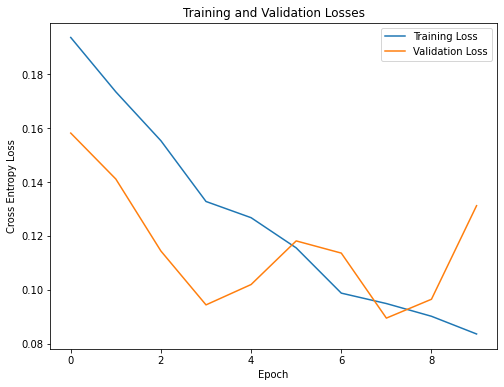

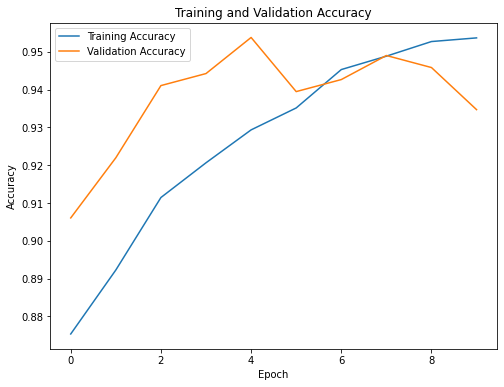

In [0]:
draw_accuracy_loss(model_eval,Epochs)

In [0]:
accuracy(trainloader,resNet18) 

Accuracy Score :  0.959516129032258
Prining Con Matrix: 
[[[5993    7]
  [  12  188]]

 [[1979  221]
  [   7 3993]]

 [[3993    7]
  [ 229 1971]]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       200
           1       0.95      1.00      0.97      4000
           2       1.00      0.90      0.94      2200

   micro avg       0.96      0.96      0.96      6400
   macro avg       0.97      0.94      0.96      6400
weighted avg       0.96      0.96      0.96      6400
 samples avg       0.96      0.96      0.96      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy(validloader,resNet18) 

Accuracy Score :  0.9506369426751592
Prining Con Matrix: 
[[[596   4]
  [  6  22]]

 [[213  15]
  [  9 391]]

 [[391   9]
  [ 15 213]]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.96      0.98      0.97       400
           2       0.96      0.93      0.95       228

   micro avg       0.96      0.95      0.96       656
   macro avg       0.92      0.90      0.91       656
weighted avg       0.96      0.95      0.96       656
 samples avg       0.96      0.96      0.96       656



# **VGG Net with BCE LOSS**

In [0]:
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,3,bias=True),                  
                     )
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

Training Loss at Epoch No  1 is  0.22490911603815134
Training Accuracy at Epoch No  1 is  0.8561290322580645
Training Time of Epoch No  1 is  1314.9839453697205
Validation Loss at Epoch No  1  is  0.17667656712186564
Validation Accuracy at Epoch No  1 is  0.8949044585987261
Validation Time of Epoch No  1 is  274.15273928642273
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  2 is  0.1563011789339925
Training Accuracy at Epoch No  2 is  0.9041935483870968
Training Time of Epoch No  2 is  259.3164219856262
Validation Loss at Epoch No  2  is  0.1614196146037548
Validation Accuracy at Epoch No  2 is  0.910828025477707
Validation Time of Epoch No  2 is  17.219745635986328
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  3 is  0.1341839562019994
Training Accuracy at Epoch No  3 is  0.9195161290322581
Training Time of Epoch No  3 is  260.0346827507019
Validation Loss at 

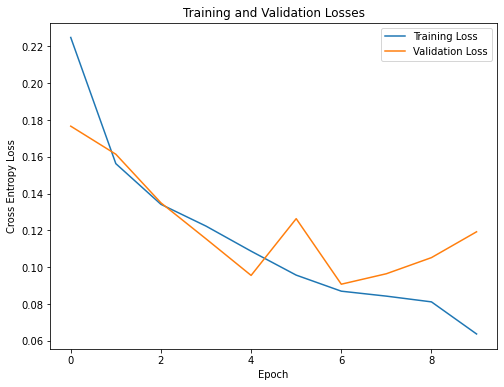

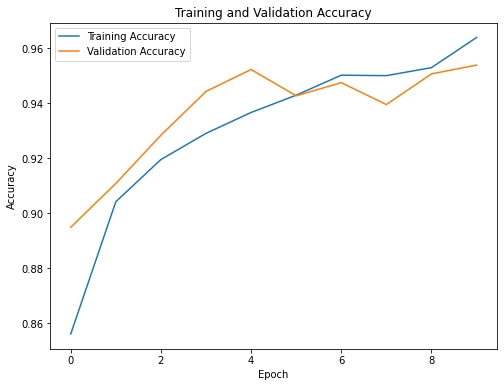

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
save_file_name = "vgg16_BCE_loss.pth"

model,model_eval = train(vgg16,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)

draw_accuracy_loss(model_eval,Epochs)

In [0]:
vgg16.load_state_dict( torch.load("/content/gdrive/My Drive/COVID19/models/vgg16_BCE_loss.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
accuracy(trainloader,vgg16) 

Accuracy Score :  0.9661290322580646
Prining Con Matrix: 
[[[5999    1]
  [  26  174]]

 [[2020  180]
  [   5 3995]]

 [[3993    7]
  [ 177 2023]]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       200
           1       0.96      1.00      0.98      4000
           2       1.00      0.92      0.96      2200

   micro avg       0.97      0.97      0.97      6400
   macro avg       0.98      0.93      0.95      6400
weighted avg       0.97      0.97      0.97      6400
 samples avg       0.97      0.97      0.97      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
vgg16.load_state_dict( torch.load("/content/gdrive/My Drive/COVID19/models/vgg16_BCE_loss.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
accuracy(validloader,vgg16) 

Accuracy Score :  0.945859872611465
Prining Con Matrix: 
[[[600   0]
  [ 11  17]]

 [[200  28]
  [  1 399]]

 [[398   2]
  [ 26 202]]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.61      0.76        28
           1       0.93      1.00      0.96       400
           2       0.99      0.89      0.94       228

   micro avg       0.95      0.94      0.95       656
   macro avg       0.97      0.83      0.89       656
weighted avg       0.96      0.94      0.95       656
 samples avg       0.95      0.96      0.95       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**ResNet18 With FOCAL LOSS-- Experiment1**

In [0]:
# Load the pretrained model from pytorch
resNet18 = models.resnet18(pretrained=True)
print(resNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 3))

Training Loss at Epoch No  1 is  0.08833950136698061
Training Accuracy at Epoch No  1 is  0.9003225806451612
Training Time of Epoch No  1 is  168.55932760238647
Validation Loss at Epoch No  1  is  0.07044594256788682
Validation Accuracy at Epoch No  1 is  0.9203821656050956
Validation Time of Epoch No  1 is  307.04081296920776
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  2 is  0.08145262480923726
Training Accuracy at Epoch No  2 is  0.9088709677419354
Training Time of Epoch No  2 is  166.68628787994385
Validation Loss at Epoch No  2  is  0.06778465291473326
Validation Accuracy at Epoch No  2 is  0.9363057324840764
Validation Time of Epoch No  2 is  12.727581024169922
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  3 is  0.07893709475715315
Training Accuracy at Epoch No  3 is  0.9119354838709678
Training Time of Epoch No  3 is  165.7706172466278
Validation Los

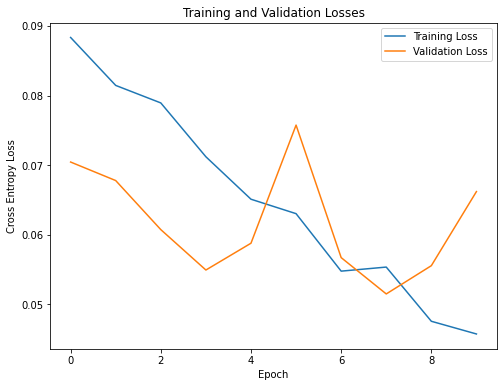

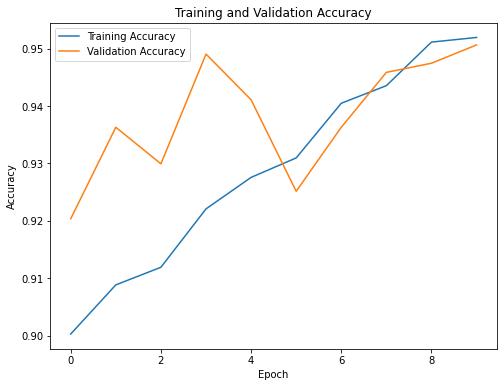

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
Epochs = 10
alpha = 2
gamma = 2
criterion = FocalLoss(gamma,alpha)
optimizer = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)
save_file_name = "res18_focal_loss.pth"

model,model_eval = train(resNet18,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)
draw_accuracy_loss(model_eval,Epochs)

In [0]:
accuracy(trainloader,resNet18) 

Accuracy Score :  0.9641935483870968
Prining Con Matrix: 
[[[5998    2]
  [   9  191]]

 [[2003  197]
  [   7 3993]]

 [[3992    8]
  [ 204 1996]]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       200
           1       0.95      1.00      0.98      4000
           2       1.00      0.91      0.95      2200

   micro avg       0.97      0.97      0.97      6400
   macro avg       0.98      0.95      0.97      6400
weighted avg       0.97      0.97      0.97      6400
 samples avg       0.97      0.97      0.97      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy(validloader,resNet18) 

Accuracy Score :  0.9506369426751592
Prining Con Matrix: 
[[[598   2]
  [  6  22]]

 [[206  22]
  [  5 395]]

 [[396   4]
  [ 22 206]]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.95      0.99      0.97       400
           2       0.98      0.90      0.94       228

   micro avg       0.96      0.95      0.95       656
   macro avg       0.95      0.89      0.92       656
weighted avg       0.96      0.95      0.95       656
 samples avg       0.96      0.96      0.95       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**ResNet18 With FOCAL LOSS-- Experiment2**

In [0]:
# Load the pretrained model from pytorch
resNet18 = models.resnet18(pretrained=True)

resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 3))

print(resNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training Loss at Epoch No  1 is  0.07819120617403139
Training Accuracy at Epoch No  1 is  0.7820967741935484
Training Time of Epoch No  1 is  175.27844071388245
Validation Loss at Epoch No  1  is  0.05433559423063401
Validation Accuracy at Epoch No  1 is  0.8869426751592356
Validation Time of Epoch No  1 is  12.984307050704956
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  2 is  0.05591684896859431
Training Accuracy at Epoch No  2 is  0.8585483870967742
Training Time of Epoch No  2 is  174.5688714981079
Validation Loss at Epoch No  2  is  0.043408621660178635
Validation Accuracy at Epoch No  2 is  0.893312101910828
Validation Time of Epoch No  2 is  12.862472295761108
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  3 is  0.04992421407673148
Training Accuracy at Epoch No  3 is  0.877258064516129
Training Time of Epoch No  3 is  178.08105397224426
Validation Loss

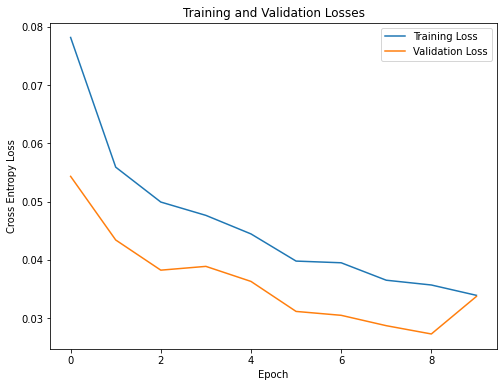

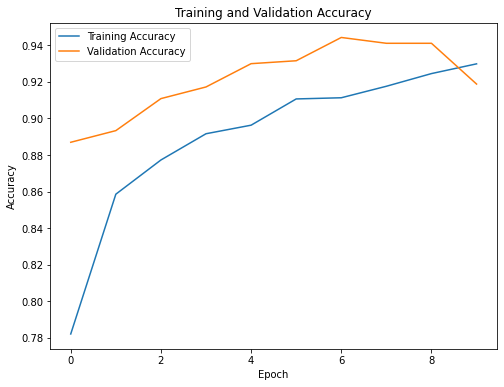

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
Epochs = 10
alpha = 1
gamma = 2
criterion = FocalLoss(gamma,alpha)
optimizer = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)
save_file_name = "res18_focal_loss2.pth"

model,model_eval = train(resNet18,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)
draw_accuracy_loss(model_eval,Epochs)

In [0]:
accuracy(trainloader,model) 

Accuracy Score :  0.9353225806451613
Prining Con Matrix: 
[[[5945   55]
  [   8  192]]

 [[2113   87]
  [ 240 3760]]

 [[3758  242]
  [  81 2119]]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       200
           1       0.98      0.94      0.96      4000
           2       0.90      0.96      0.93      2200

   micro avg       0.94      0.95      0.94      6400
   macro avg       0.88      0.95      0.92      6400
weighted avg       0.94      0.95      0.95      6400
 samples avg       0.94      0.95      0.94      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy(validloader,model) 

Accuracy Score :  0.9187898089171974
Prining Con Matrix: 
[[[596   4]
  [  3  25]]

 [[215  13]
  [ 32 368]]

 [[371  29]
  [ 13 215]]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        28
           1       0.97      0.92      0.94       400
           2       0.88      0.94      0.91       228

   micro avg       0.93      0.93      0.93       656
   macro avg       0.90      0.92      0.91       656
weighted avg       0.93      0.93      0.93       656
 samples avg       0.93      0.93      0.93       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**ResNet18 With FOCAL LOSS-- Experiment3**

In [42]:
# Load the pretrained model from pytorch
resNet18 = models.resnet18(pretrained=True)

resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 3))

print(resNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNet18.to(device)
Epochs = 10
alpha = 1
gamma = 2.5
criterion = FocalLoss(gamma,alpha)
optimizer = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)
save_file_name = "res18_focal_loss3.pth"

model,model_eval = train(resNet18,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)
draw_accuracy_loss(model_eval,Epochs)

###**VGG16 with Focal Loss-- Experiment1**


In [0]:
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,3,bias=True),                  
                     )
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Epochs = 10
criterion = FocalLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
save_file_name = "vgg16_focal_loss.pth"

model,model_eval = train(vgg16,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)


Training Loss at Epoch No  1 is  0.0839429908585284
Training Accuracy at Epoch No  1 is  0.9074193548387097
Training Time of Epoch No  1 is  207.29278254508972
Validation Loss at Epoch No  1  is  0.08138586083652487
Validation Accuracy at Epoch No  1 is  0.9219745222929936
Validation Time of Epoch No  1 is  14.498941898345947
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  2 is  0.07109785480830337
Training Accuracy at Epoch No  2 is  0.9190322580645162
Training Time of Epoch No  2 is  205.22854471206665
Validation Loss at Epoch No  2  is  0.0693566598840485
Validation Accuracy at Epoch No  2 is  0.9410828025477707
Validation Time of Epoch No  2 is  14.384058952331543
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  3 is  0.06628213301661515
Training Accuracy at Epoch No  3 is  0.9282258064516129
Training Time of Epoch No  3 is  205.19498133659363
Validation Loss

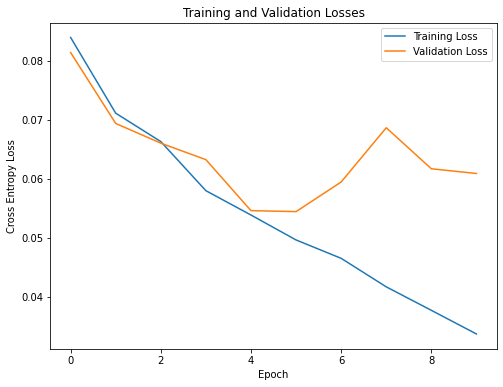

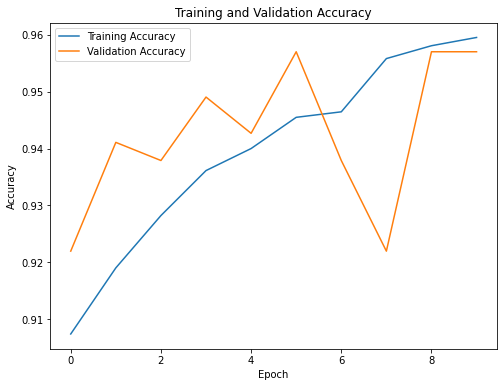

In [0]:
draw_accuracy_loss(model_eval,Epochs)

In [0]:
accuracy(trainloader,vgg16)

Accuracy Score :  0.9725806451612903
Prining Con Matrix: 
[[[5992    8]
  [  10  190]]

 [[2139   61]
  [  87 3913]]

 [[3920   80]
  [  67 2133]]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       200
           1       0.98      0.98      0.98      4000
           2       0.96      0.97      0.97      2200

   micro avg       0.98      0.97      0.98      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.98      0.97      0.98      6400
 samples avg       0.97      0.97      0.97      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy(validloader,vgg16)

Accuracy Score :  0.9570063694267515
Prining Con Matrix: 
[[[600   0]
  [  5  23]]

 [[212  16]
  [  9 391]]

 [[390  10]
  [ 16 212]]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        28
           1       0.96      0.98      0.97       400
           2       0.95      0.93      0.94       228

   micro avg       0.96      0.95      0.96       656
   macro avg       0.97      0.91      0.94       656
weighted avg       0.96      0.95      0.96       656
 samples avg       0.96      0.96      0.96       656



**VGG16 with Focal Loss -- Experiment 2:**

In [0]:
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,3,bias=True),                  
                     )
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Epochs = 10
criterion = FocalLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)
save_file_name = "vgg16_focal_loss2.pth"

model,model_eval = train(vgg16,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)


Training Loss at Epoch No  1 is  0.1342915151057945
Training Accuracy at Epoch No  1 is  0.8425806451612903
Training Time of Epoch No  1 is  221.07238626480103
Validation Loss at Epoch No  1  is  0.10819104507233307
Validation Accuracy at Epoch No  1 is  0.8885350318471338
Validation Time of Epoch No  1 is  15.488693237304688
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  2 is  0.09401365306258443
Training Accuracy at Epoch No  2 is  0.8953225806451612
Training Time of Epoch No  2 is  220.01124811172485
Validation Loss at Epoch No  2  is  0.10427518801134862
Validation Accuracy at Epoch No  2 is  0.8980891719745223
Validation Time of Epoch No  2 is  15.09099006652832
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  3 is  0.0843617250448874
Training Accuracy at Epoch No  3 is  0.9082258064516129
Training Time of Epoch No  3 is  219.31501364707947
Validation Loss 

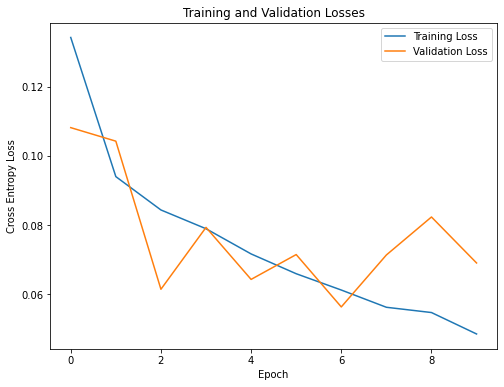

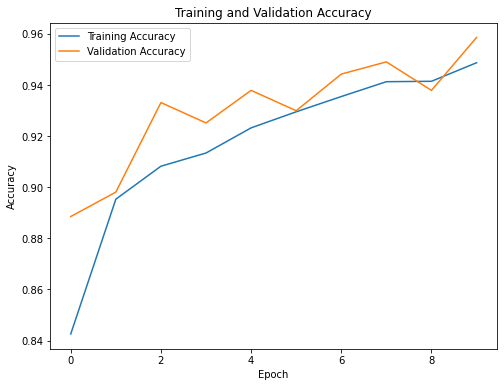

In [0]:
draw_accuracy_loss(model_eval,Epochs)

In [0]:
accuracy(trainloader,vgg16)

Accuracy Score :  0.9729032258064516
Prining Con Matrix: 
[[[5993    7]
  [  16  184]]

 [[2083  117]
  [  29 3971]]

 [[3968   32]
  [ 114 2086]]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       200
           1       0.97      0.99      0.98      4000
           2       0.98      0.95      0.97      2200

   micro avg       0.98      0.98      0.98      6400
   macro avg       0.97      0.95      0.96      6400
weighted avg       0.98      0.98      0.98      6400
 samples avg       0.98      0.98      0.98      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy(validloader,vgg16)

Accuracy Score :  0.9585987261146497
Prining Con Matrix: 
[[[597   3]
  [  6  22]]

 [[213  15]
  [  6 394]]

 [[395   5]
  [ 15 213]]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        28
           1       0.96      0.98      0.97       400
           2       0.98      0.93      0.96       228

   micro avg       0.96      0.96      0.96       656
   macro avg       0.94      0.90      0.92       656
weighted avg       0.96      0.96      0.96       656
 samples avg       0.97      0.96      0.96       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**VGG16 With Focal Loss -- Experiment3**

In [0]:
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,3,bias=True),                  
                     )
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Epochs = 10
alpha = 0.25
gamma = 2
criterion = FocalLoss(gamma,alpha)
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001,momentum= 0.9)
save_file_name = "vgg16_focal_loss3.pth"

model,model_eval = train(vgg16,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)


Training Loss at Epoch No  1 is  0.026730163175492518
Training Accuracy at Epoch No  1 is  0.5953225806451613
Training Time of Epoch No  1 is  207.32002115249634
Validation Loss at Epoch No  1  is  0.02076919394646101
Validation Accuracy at Epoch No  1 is  0.8089171974522293
Validation Time of Epoch No  1 is  14.410901308059692
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  2 is  0.020200800777322822
Training Accuracy at Epoch No  2 is  0.7625806451612903
Training Time of Epoch No  2 is  206.09363675117493
Validation Loss at Epoch No  2  is  0.017092718380936393
Validation Accuracy at Epoch No  2 is  0.8359872611464968
Validation Time of Epoch No  2 is  14.655307292938232
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  3 is  0.017421248475870777
Training Accuracy at Epoch No  3 is  0.7988709677419354
Training Time of Epoch No  3 is  206.15733361244202
Validatio

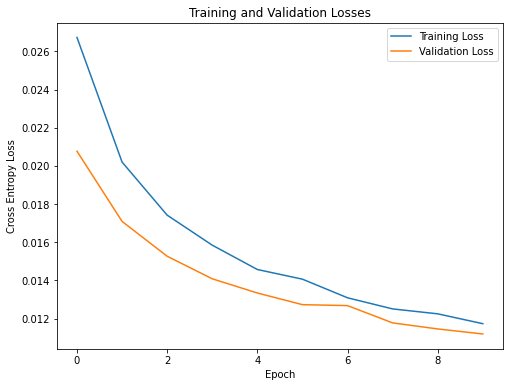

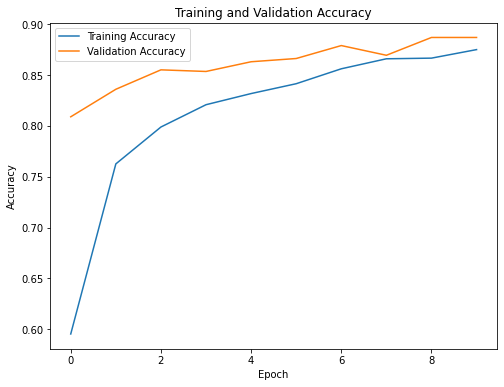

In [0]:
draw_accuracy_loss(model_eval,Epochs)

In [0]:
accuracy(trainloader,vgg16)

Accuracy Score :  0.8925806451612903
Prining Con Matrix: 
[[[5999    1]
  [ 141   59]]

 [[1889  311]
  [ 176 3824]]

 [[3825  175]
  [ 324 1876]]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.29      0.45       200
           1       0.92      0.96      0.94      4000
           2       0.91      0.85      0.88      2200

   micro avg       0.92      0.90      0.91      6400
   macro avg       0.94      0.70      0.76      6400
weighted avg       0.92      0.90      0.91      6400
 samples avg       0.92      0.91      0.91      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy(validloader,vgg16)

Accuracy Score :  0.8869426751592356
Prining Con Matrix: 
[[[600   0]
  [ 26   2]]

 [[195  33]
  [ 15 385]]

 [[384  16]
  [ 36 192]]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.07      0.13        28
           1       0.92      0.96      0.94       400
           2       0.92      0.84      0.88       228

   micro avg       0.92      0.88      0.90       656
   macro avg       0.95      0.63      0.65       656
weighted avg       0.93      0.88      0.89       656
 samples avg       0.92      0.91      0.91       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**VGG Focal Loss -- Experiment 4**

In [0]:
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,3,bias=True),                  
                     )
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Epochs = 20
alpha = 0.75
gamma = 2
criterion = FocalLoss(gamma,alpha)
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001,momentum= 0.9)
save_file_name = "vgg16_focal_loss4.pth"

model,model_eval = train(vgg16,criterion,optimizer,trainloader,validloader,save_file_name,Epochs)


Training Loss at Epoch No  1 is  0.06671781852721206
Training Accuracy at Epoch No  1 is  0.72
Training Time of Epoch No  1 is  205.62100052833557
Validation Loss at Epoch No  1  is  0.04764373468792742
Validation Accuracy at Epoch No  1 is  0.8503184713375797
Validation Time of Epoch No  1 is  14.345576524734497
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  2 is  0.04663282105278584
Training Accuracy at Epoch No  2 is  0.8320967741935484
Training Time of Epoch No  2 is  205.11389446258545
Validation Loss at Epoch No  2  is  0.040596945555346785
Validation Accuracy at Epoch No  2 is  0.8726114649681529
Validation Time of Epoch No  2 is  14.230210542678833
Model is Successfully Saved
-------------------------------------------------------
Training Loss at Epoch No  3 is  0.03991902778165475
Training Accuracy at Epoch No  3 is  0.8606451612903225
Training Time of Epoch No  3 is  206.2962031364441
Validation Loss at Epoch No

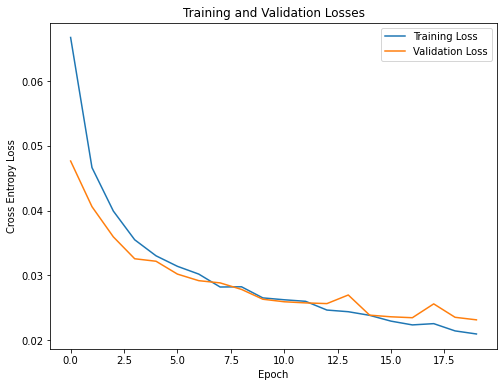

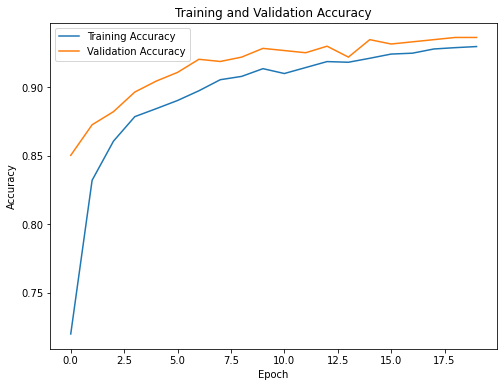

In [0]:
draw_accuracy_loss(model_eval,Epochs)

In [0]:
accuracy(trainloader,vgg16)

Accuracy Score :  0.9429032258064516
Prining Con Matrix: 
[[[5986   14]
  [  34  166]]

 [[1970  230]
  [  60 3940]]

 [[3929   71]
  [ 227 1973]]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       200
           1       0.94      0.98      0.96      4000
           2       0.97      0.90      0.93      2200

   micro avg       0.95      0.95      0.95      6400
   macro avg       0.94      0.90      0.92      6400
weighted avg       0.95      0.95      0.95      6400
 samples avg       0.95      0.95      0.95      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
accuracy(validloader,vgg16)

Accuracy Score :  0.9363057324840764
Prining Con Matrix: 
[[[598   2]
  [  8  20]]

 [[206  22]
  [ 12 388]]

 [[391   9]
  [ 22 206]]]
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.95      0.97      0.96       400
           2       0.96      0.90      0.93       228

   micro avg       0.95      0.94      0.94       656
   macro avg       0.94      0.86      0.90       656
weighted avg       0.95      0.94      0.94       656
 samples avg       0.95      0.95      0.95       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loading Saved Models AND Storing Their Results in CSV

**VGG Results**

In [0]:
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True), 
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,3,bias=True),                  
                     )

In [0]:
vgg16.load_state_dict( torch.load("/content/gdrive/My Drive/COVID19/models/Vgg16/vgg16_BCE_loss.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

csv_file_name = '/content/gdrive/My Drive/COVID19/results/vgg16_BCE_loss.csv'
results = storeTestResults(testloader,vgg16,csv_file_name)

**RESNET18 Results:**

In [0]:
# Load the pretrained model from pytorch
resNet18 = models.resnet18(pretrained=True)
resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 3))

In [0]:
resNet18.load_state_dict( torch.load("/content/gdrive/My Drive/COVID19/models/ResNet18/res18_BCE_loss2.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resNet18.to(device)

csv_file_name = '/content/gdrive/My Drive/COVID19/results/res18_BCE_loss2.csv'
results = storeTestResults(testloader,resNet18,csv_file_name)